In [10]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import random_split
import pytorch_lightning as pl
import torch
from torch import nn
from transformers import AutoTokenizer, AutoModel
%load_ext tensorboard
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
class GetFullDF:
    def __init__(self):
        self.df = None
    def __call__(self):
        if self.df is None:
            df = pd.concat([
        #         pd.read_csv(os.path.join('results_dir', 'results.csv')),
        #         pd.read_csv(os.path.join('results_dir2', 'results.csv')),
        #         pd.read_csv(os.path.join('results_dir3', 'results.csv')),
        #         pd.read_csv(os.path.join('results_dir4', 'results.csv')),
        #         pd.read_csv(os.path.join('results_32test/results_gpt2finetuned', 'results.csv')),
        #         pd.read_csv(os.path.join('results_32test//results_gpt2', 'results.csv')),
        #         pd.read_csv(os.path.join('results_32test/results_gptj', 'results.csv')),
        #         pd.read_csv(os.path.join('results/results_gpt2orig_4', 'results.csv')),
                pd.read_csv(os.path.join('results_old/results_gpt2', 'results.csv')),
                pd.read_csv(os.path.join('results_old/results_gpt2orig', 'results.csv')),
                pd.read_csv(os.path.join('results_old/results_gpt2orig_2', 'results.csv')),
                pd.read_csv(os.path.join('results_old/results_gpt2orig_3', 'results.csv')),
#                 pd.read_csv(os.path.join('/scratch/mcinerney.de/metaicl/results/results_gpt2orig', 'results.csv')),
            ])
            df = df.drop_duplicates(['task', 'train_indices', 'checkpoint'])
            df = df.reset_index()
            df['sampling'] = 'within_task_random'
            df['method'] = 'in_context'
            df['descriptor'] = df[['checkpoint', 'sampling', 'method']].apply(tuple, axis=1)
            self.df = df
        return self.df
get_full_df = GetFullDF()
def evaluate_prediction_dfs(train_df, val_df):
    print('train corr: %f, val corr: %f' % (
        train_df.regression_predictions.corr(train_df.result),
        val_df.regression_predictions.corr(val_df.result)))
    chart = sns.scatterplot(data=train_df, x='result', y='regression_predictions', hue='task')
    plt.show()
    chart = sns.scatterplot(data=val_df, x='result', y='regression_predictions', hue='task')
    plt.show()

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


# Data

In [11]:
def get_breakdown(df):
    ckpts = sorted(list(set(df.checkpoint)))
    tasks = sorted(list(set(df.task)))
    samplings = sorted(list(set(df.sampling)))
    methods = sorted(list(set(df.method)))
    breakdown_df = pd.DataFrame({
        task: {
            (ch, sampling, method): len(df[(df.task == task) & (df.checkpoint == ch) & (df.sampling == sampling) & (df.method == method)])
            for ch in ckpts for sampling in samplings for method in methods
        } for task in tasks}).transpose()
    print(len(breakdown_df))
    return breakdown_df
get_breakdown(get_full_df())

4


,checkpoints/metaicl/hr_to_lr/model.pt,gpt2-large
,within_task_random,within_task_random
,in_context,in_context
biomrc,0,280
commonsense_qa,1000,1000
piqa,0,1000
qasc,225,223


In [12]:
def get_prompt(train_samples):
    train_samples = eval(train_samples)
    return '\n\n'.join(['input: %s\noutput: %s\n' % (dp['input'], dp['output']) for dp in train_samples])
class PromptPerformanceDataset(Dataset):
    def __init__(self, df):
        self.df = df
    def __len__(self):
        return len(self.df)
    def __getitem__(self, index):
        row = self.df.iloc[index]
        return dict(
            prompt=get_prompt(row.train_samples),
            label=row.result,
        )
class PromptsPerformanceData(pl.LightningDataModule):
    def __init__(self, get_df_func, train_percent=.8, val_percent=.1, seed=0, **dataloader_kwargs):
        super().__init__()
        self.get_df_func = get_df_func
        self.dataloader_kwargs = dataloader_kwargs
        self._train, self._val, self._test = None, None, None
        self.train_percent, self.val_percent, self.seed = train_percent, val_percent, seed
    def setup(self, stage=None):
        df = self.get_df_func()
        df[df.k != 0]
        length = len(df)
        train_length = int(length * self.train_percent)
        val_length = int(length * self.val_percent)
        lengths = [train_length, val_length, length - train_length - val_length]
        rows = [r for i, r in df.iterrows()]
        splits = random_split(rows, lengths, generator=torch.Generator().manual_seed(self.seed))
        self._train, self._val, self._test = [
            PromptPerformanceDataset(pd.DataFrame(list(x))) for x in splits]
    def train_dataloader(self):
        return DataLoader(self._train, **self.dataloader_kwargs, shuffle=True)
    def val_dataloader(self):
        return DataLoader(self._val, **self.dataloader_kwargs)
    def test_dataloader(self):
        return DataLoader(self._test, **self.dataloader_kwargs)

# Linear Regression on per-example Binary Variables

In [40]:
def get_features(indices):
    x = np.zeros(200)
    x[np.array(indices)] = 1
    return x
def getxy(df):
    X = np.stack(df.apply(lambda r: get_features(eval(r.train_indices)), axis=1))
    y = np.array(df.result)
    return X, y
def setup_and_train_linear_regression(task, checkpoint, save_coefs=False):
    def get_df():
        df = get_full_df()
        return df[(df.task == task) & (df.checkpoint == checkpoint)]
    dm = PromptsPerformanceData(get_df)
    dm.setup()
    X_train, y_train = getxy(dm._train.df)
    print('train shapes: X - %s, y - %s' % (str(X_train.shape), str(y_train.shape)))
    X_val, y_val = getxy(dm._val.df)
    print('val shapes: X - %s, y - %s' % (str(X_val.shape), str(y_val.shape)))
    model = sm.OLS(y_train, sm.add_constant(X_train)).fit()
#     print(model.summary())
#     model = LinearRegression()
#     model.fit(X_train, y_train)
    if save_coefs:
        if not os.path.exists('regcoef'):
            os.mkdir('regcoef')
        if not os.path.exists(os.path.join('regcoef', checkpoint.replace('/', '-'))):
            os.mkdir(os.path.join('regcoef', checkpoint.replace('/', '-')))
#         np.save(os.path.join('regcoef', checkpoint.replace('/', '-'), '%s.npy' % task), model.coef_)
        np.save(os.path.join('regcoef', checkpoint.replace('/', '-'), '%s.npy' % task), model.params[1:])
    return dm, model
def get_prediction_dfs_linear_regression(dm, model):
    X_train, y_train = getxy(dm._train.df)
#     y_train_pred = model.predict(X_train)
    y_train_pred = model.predict(sm.add_constant(X_train))
    train_df = dm._train.df.copy()
    train_df['regression_predictions'] = y_train_pred
    X_val, y_val = getxy(dm._val.df)
#     y_val_pred = model.predict(X_val)
    y_val_pred = model.predict(sm.add_constant(X_val))
    val_df = dm._val.df.copy()
    val_df['regression_predictions'] = y_val_pred
#     print('train regression score: %s, val regression score: %s' % (model.score(X_train, y_train), model.score(X_val, y_val)))
    return train_df, val_df

train shapes: X - (800, 200), y - (800,)
val shapes: X - (100, 200), y - (100,)
train corr: 0.686652, val corr: 0.363504


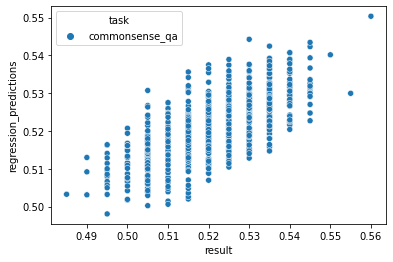

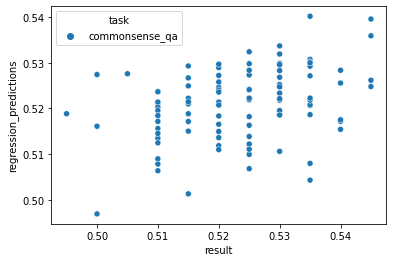

In [41]:
dm, model = setup_and_train_linear_regression('commonsense_qa', 'checkpoints/metaicl/hr_to_lr/model.pt', save_coefs=True)
train_df, val_df = get_prediction_dfs_linear_regression(dm, model)
evaluate_prediction_dfs(train_df, val_df)

train shapes: X - (800, 200), y - (800,)
val shapes: X - (100, 200), y - (100,)
train corr: 0.768749, val corr: 0.543682


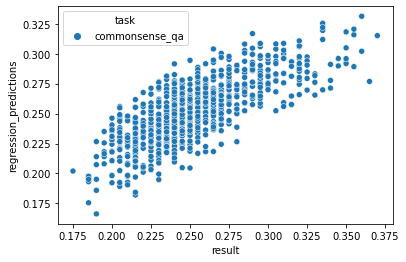

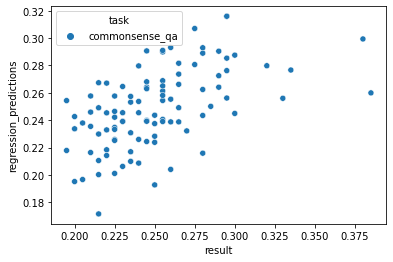

In [42]:
dm, model = setup_and_train_linear_regression('commonsense_qa', 'gpt2-large', save_coefs=True)
train_df, val_df = get_prediction_dfs_linear_regression(dm, model)
evaluate_prediction_dfs(train_df, val_df)

train shapes: X - (800, 200), y - (800,)
val shapes: X - (100, 200), y - (100,)
train corr: 0.692494, val corr: 0.308408


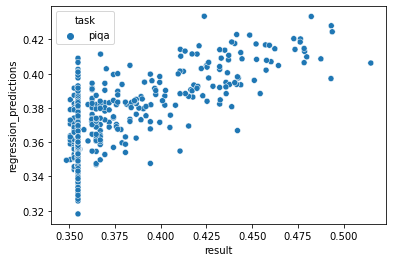

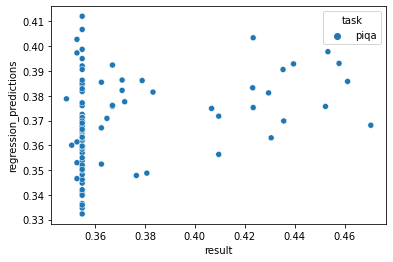

In [43]:
dm, model = setup_and_train_linear_regression('piqa', 'gpt2-large', save_coefs=True)
train_df, val_df = get_prediction_dfs_linear_regression(dm, model)
evaluate_prediction_dfs(train_df, val_df)

train shapes: X - (224, 200), y - (224,)
val shapes: X - (28, 200), y - (28,)
train corr: 0.973481, val corr: -0.029718


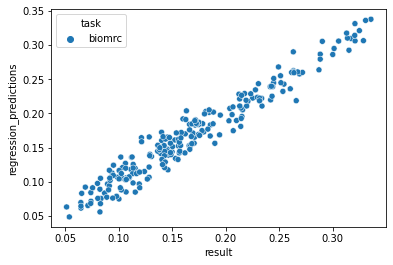

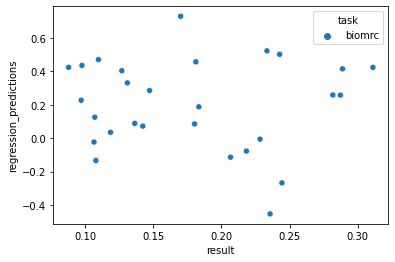

In [44]:
dm, model = setup_and_train_linear_regression('biomrc', 'gpt2-large', save_coefs=True)
train_df, val_df = get_prediction_dfs_linear_regression(dm, model)
evaluate_prediction_dfs(train_df, val_df)

# Bert Regression

### Model

In [9]:
class StringRegressionModel(pl.LightningModule):
    def __init__(self, lr=1e-4):
        super().__init__()
        self.model = AutoModel.from_pretrained('roberta-base')
        self.linear = nn.Linear(768, 1)
        self.loss = nn.MSELoss()
        self.lr = lr
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)
    def forward(self, batch):
        out = self.model(**batch['text'])
        predictions = self.linear(out[1]).squeeze(-1)
        return predictions
    def shared_step(self, batch, step_type):
        predictions = self(batch)
        loss = self.loss(predictions, batch['label'])
        self.log('loss/%s' % step_type, loss.item())
        return loss
    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, 'train')
    def validation_step(self, batch, batch_idx):
        return self.shared_step(batch, 'val')
    def test_step(self, batch, batch_idx):
        return self.shared_step(batch, 'test')
    def predict_step(self, batch, batch_idx):
        return self(batch).cpu().numpy()
class CollateFn:
    def __init__(self):
        self.tokenizer = AutoTokenizer.from_pretrained('roberta-base')
    def __call__(self, instances):
        return dict(
            text=self.tokenizer([self.tokenizer.cls_token + ' ' + i['prompt'] for i in instances], return_tensors='pt', padding=True, truncation=True),
            label=torch.tensor([i['label'] for i in instances], dtype=torch.float32)
        )
def setup_and_train_roberta_regression(task, checkpoint, epochs=10, batch_size=64, lr=1e-4, seed=0):
    def get_df():
        df = get_full_df()
        return df[(df.task == task) & (df.checkpoint == checkpoint)]
    dm = PromptsPerformanceData(get_df, batch_size=batch_size, collate_fn=CollateFn(), seed=seed)
    dm.setup()
    model = StringRegressionModel(lr=lr)
    trainer = pl.Trainer(gpus=1, max_epochs=epochs, log_every_n_steps=10)
    trainer.fit(model, datamodule=dm)
    return trainer, dm, model
def get_prediction_dfs_roberta_regression(trainer, dm, model):
    train_reg_preds = np.concatenate(trainer.predict(model, dm.train_dataloader()))
    train_df = dm._train.df.copy()
    train_df['regression_predictions'] = train_reg_preds
    val_reg_preds = np.concatenate(trainer.predict(model, dm.val_dataloader()))
    val_df = dm._val.df.copy()
    val_df['regression_predictions'] = val_reg_preds
    return train_df, val_df

### Training and evaluating the model

In [17]:
%tensorboard --logdir=lightning_logs --port 6060

Reusing TensorBoard on port 6060 (pid 23708), started 9:14:59 ago. (Use '!kill 23708' to kill it.)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type         | Params
----------------------------------------
0 | model  | RobertaModel | 124 M

/home/mcinerney.de/.conda/envs/metaicl/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/mcinerney.de/.conda/envs/metaicl/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mcinerney.de/.conda/envs/metaicl/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:495: PossibleUserWarning: Your `predict_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(
/home/mcinerney.de/.conda/envs/metaicl/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mcinerney.de/.conda/envs/metaicl/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(



train corr: -0.028669, val corr: 0.109313


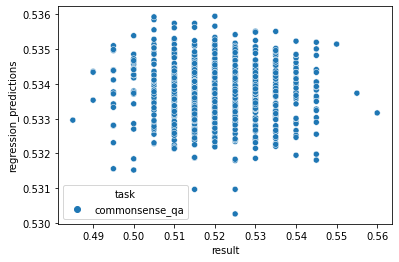

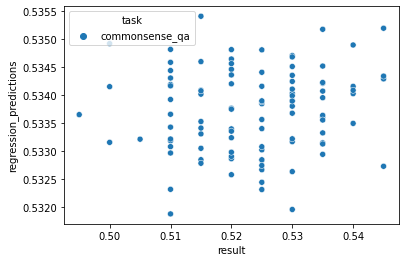

In [13]:
trainer, dm, model = setup_and_train_roberta_regression('commonsense_qa', 'checkpoints/metaicl/hr_to_lr/model.pt')
train_df, val_df = get_prediction_dfs_roberta_regression(trainer, dm, model)
evaluate_prediction_dfs(train_df, val_df)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type         | Params
----------------------------------------
0 | model  | RobertaModel | 124 M

/home/mcinerney.de/.conda/envs/metaicl/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/mcinerney.de/.conda/envs/metaicl/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mcinerney.de/.conda/envs/metaicl/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:495: PossibleUserWarning: Your `predict_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(
/home/mcinerney.de/.conda/envs/metaicl/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mcinerney.de/.conda/envs/metaicl/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(



train corr: 0.005981, val corr: 0.600650


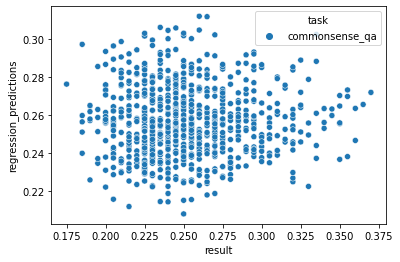

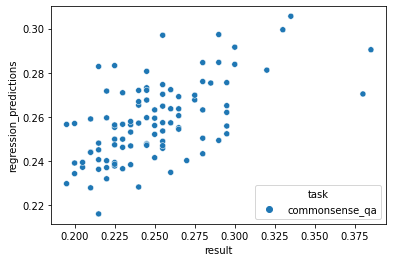

In [14]:
trainer, dm, model = setup_and_train_roberta_regression('commonsense_qa', 'gpt2-large', epochs=20, lr=1e-5)
train_df, val_df = get_prediction_dfs_roberta_regression(trainer, dm, model)
evaluate_prediction_dfs(train_df, val_df)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type         | Params
----------------------------------------
0 | model  | RobertaModel | 124 M

/home/mcinerney.de/.conda/envs/metaicl/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/mcinerney.de/.conda/envs/metaicl/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mcinerney.de/.conda/envs/metaicl/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:495: PossibleUserWarning: Your `predict_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(
/home/mcinerney.de/.conda/envs/metaicl/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mcinerney.de/.conda/envs/metaicl/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(



train corr: -0.007926, val corr: 0.100421


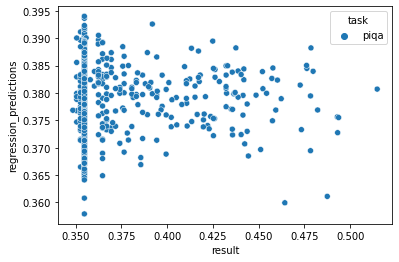

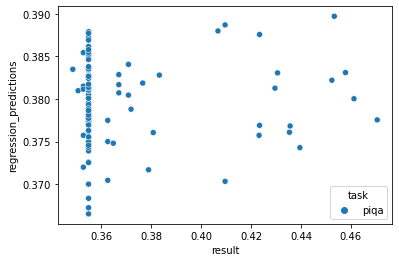

In [15]:
trainer, dm, model = setup_and_train_roberta_regression('piqa', 'gpt2-large', epochs=20, lr=1e-5)
train_df, val_df = get_prediction_dfs_roberta_regression(trainer, dm, model)
evaluate_prediction_dfs(train_df, val_df)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type         | Params
----------------------------------------
0 | model  | RobertaModel | 124 M

/home/mcinerney.de/.conda/envs/metaicl/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/mcinerney.de/.conda/envs/metaicl/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mcinerney.de/.conda/envs/metaicl/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:495: PossibleUserWarning: Your `predict_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(
/home/mcinerney.de/.conda/envs/metaicl/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mcinerney.de/.conda/envs/metaicl/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(



train corr: -0.012166, val corr: 0.753942


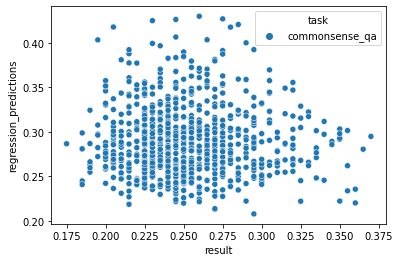

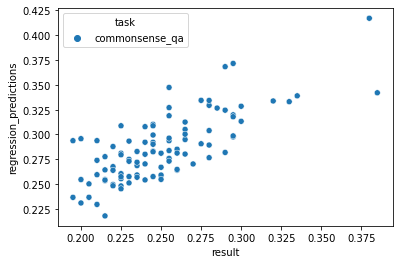

In [16]:
trainer, dm, model = setup_and_train_roberta_regression('commonsense_qa', 'gpt2-large', epochs=40, lr=1e-5)
train_df, val_df = get_prediction_dfs_roberta_regression(trainer, dm, model)
evaluate_prediction_dfs(train_df, val_df)

# Per-example Correlation Coefficient Regression

For a given example, can we estimate how the correlation coefficient between including the example in the prompt and the score? If so, we would be able to estimate which examples are more positively correlated and use them in the prompt.

In [47]:
dm, model = setup_and_train_linear_regression('commonsense_qa', 'gpt2-large')
print(model.params)

train shapes: X - (800, 200), y - (800,)
val shapes: X - (100, 200), y - (100,)
[ 1.10360433e-01  5.56854590e-03  1.67340245e-03  1.01215002e-02
  1.63854902e-03 -3.78488040e-03  8.48464262e-04  1.38592095e-02
  4.71245523e-04  1.40243784e-02  6.93391081e-03  1.18040310e-02
  8.12578418e-04  1.40778652e-02  2.61235653e-03  9.99750215e-03
  8.64778540e-04  1.79342541e-02  1.97617437e-02  9.48037467e-03
  1.32193265e-02  1.01504012e-02  2.56967945e-02  1.16276525e-02
  6.13853560e-03  3.89420589e-03  3.34467507e-03  1.59818567e-03
  2.33914333e-02  2.55347517e-03 -2.56980208e-03  1.13543262e-02
  5.68367469e-03  6.18302903e-03  1.38731294e-02  1.11321816e-03
  1.13034874e-02  1.90235324e-03  1.78030507e-02  8.24931439e-03
  5.05996067e-03  2.25869581e-02  7.68092809e-03  9.81920020e-03
  1.59553503e-02  1.77324024e-02  1.79541813e-02  1.27667528e-02
  2.79136904e-03  3.51705806e-03  1.35547525e-02  1.46974029e-05
  4.21859268e-04  7.98258268e-03  1.70612678e-02 -1.10195113e-03
  2.259704

train shapes: X - (800, 200), y - (800,)
val shapes: X - (100, 200), y - (100,)


,task,input,output,options,coefficient
98,commonsense_qa,Where can you watch information on lizards?,documentary,"[on the back of a cereal box., costa rica, gar...",0.001032
194,commonsense_qa,"Dogs run around all day, it's a good thing the...",four legs,"[pointed ears, fleas, bones, tails, four legs]",0.015831
107,commonsense_qa,Where are seats most likely bleachers?,hockey game,"[movies, opera, theater, lecture hall, hockey ...",0.013162
10,commonsense_qa,What is someone likely to experience when havi...,enjoyment,"[enjoyment, euphoria, excitement, crying, laug...",0.011804
66,commonsense_qa,"The children were making each other laugh, the...",tickle,"[play ball, reading a book, jump rope, tickle,...",0.002682
...,...,...,...,...,...
90,commonsense_qa,"Joe is looking for his comb, which he keeps ne...",medicine cabinet,"[bedstand, medicine cabinet, suitcase, barber ...",0.011571
80,commonsense_qa,"His cupboards were barren, so he had to go to ...",eat,"[earn money, eat, take bus, make money, sleep]",-0.008441
142,commonsense_qa,"The saw was not necessary for car repair, so w...",tool kit,"[tool shed, tool box, tool kit, hardware store...",-0.004273
183,commonsense_qa,Diligently taking care of proposals got him go...,results,"[paper work, getting work done, marriage, resu...",0.002028


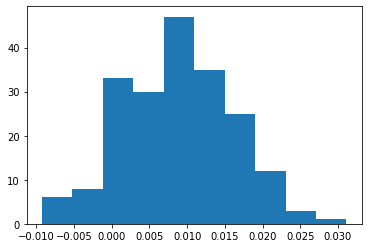

In [49]:
dm, model = setup_and_train_linear_regression('commonsense_qa', 'gpt2-large')
# plt.hist(model.coef_)
plt.hist(model.params[1:])
df = get_full_df()
df = df[(df.task == 'commonsense_qa') & (df.checkpoint == 'gpt2-large')]
examples_df = {}
for i, row in df.iterrows():
    for index, example in zip(eval(row.train_indices), eval(row.train_samples)):
#         example['coefficient'] = model.coef_[index]
        example['coefficient'] = model.params[index + 1]
        examples_df[index] = example
examples_df = pd.DataFrame(examples_df).transpose()
examples_df

### Data